In [15]:
import os
import xarray as xr
import numpy as np
import cftime
import glob
import matplotlib.pyplot as plt

from osprey.utils.folders import folders
from osprey.utils.time import get_startleg, get_year, count_total_steps, get_forecast_year
from osprey.means.means import timemean, spacemean
from osprey.means.eof import change_timeaxis
from osprey.actions.reader import elements
from osprey.utils import run_cdo
from osprey.actions.forecaster import forecaster_EOF_restart
from osprey.actions.reader import reader_rebuilt 

In [2]:
expname = "FE01"
var = "tn"
ndim ="3D"
endleg = 11
yearspan = 5
yearleap = 10
startleg = get_startleg(endleg, yearspan)
startyear = get_year(startleg)
endyear = get_year(endleg)
window = endyear - startyear + 1
dirs = folders(expname)

In [13]:
data = forecaster_EOF_restart(expname, endleg, yearspan, yearleap, reco=False)

2024-08-30 14:25:32,061 - INFO -  File to be loaded ['/ec/res4/scratch/itas/martini/FE01/011/FE01_00058432_restart.nc']


Command: 'cdo -selname,tn /ec/res4/scratch/itas/martini/FE01/007/FE01*_restart.nc /ec/res4/scratch/itas/martini/FE01/007/aux.nc' 

/bin/sh: which: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `which'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `module'
/bin/sh: ml: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `ml'

Command: 'cdo -settaxis,1996-01-01,00:00:00,1year /ec/res4/scratch/itas/martini/FE01/007/aux.nc /ec/res4/scratch/itas/martini/FE01/007/tn_7.nc' 

/bin/sh: which: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `which'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `module'
/bin/sh: ml: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `ml'

File /ec/res4/scratch

In [4]:
data

<xarray.Dataset> Size: 96MB
Dimensions:       (y: 148, x: 180, nav_lev: 31, time_counter: 1)
Coordinates:
  * nav_lev       (nav_lev) float32 124B 5.0 15.0 25.0 ... 4.75e+03 5.25e+03
  * time_counter  (time_counter) float32 4B 5.843e+04
Dimensions without coordinates: y, x
Data variables: (12/41)
    nav_lon       (y, x) float32 107kB dask.array<chunksize=(135, 180), meta=np.ndarray>
    nav_lat       (y, x) float32 107kB dask.array<chunksize=(135, 180), meta=np.ndarray>
    kt            float64 8B ...
    ndastp        float64 8B ...
    adatrj        float64 8B ...
    ntime         float64 8B ...
    ...            ...
    sshn          (time_counter, y, x) float64 213kB dask.array<chunksize=(1, 135, 180), meta=np.ndarray>
    un            (time_counter, nav_lev, y, x) float64 7MB dask.array<chunksize=(1, 1, 135, 180), meta=np.ndarray>
    vn            (time_counter, nav_lev, y, x) float64 7MB dask.array<chunksize=(1, 1, 135, 180), meta=np.ndarray>
    tn            (time_counter, nav_lev, y, x) float64 7MB dask.array<chunksize=(1, 1, 1, 180), meta=np.ndarray>
    sn            (time_counter, nav_lev, y, x) float64 7MB dask.array<chunksize=(1, 1, 135, 180), meta=np.ndarray>
    rhop          (time_counter, nav_lev, y, x) float64 7MB dask.array<chunksize=(1, 1, 135, 180), meta=np.ndarray>
Attributes:
    file_name:  /ec/res4/scratch/itas/martini/FE01/011/FE01_00058432_restart.nc
    TimeStamp:  30/08/2024 12:42:09 -0000

In [8]:
rdata = reader_rebuilt(expname, endleg, endleg)

2024-08-30 14:22:31,043 - INFO -  File to be loaded ['/ec/res4/scratch/itas/martini/FE01/011/FE01_00058432_restart.nc']


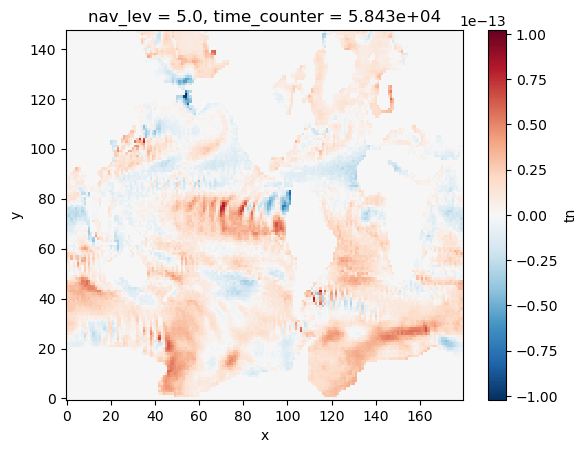

In [9]:
delta = data['tn'].isel(time_counter=0,nav_lev=0)-rdata['tn'].isel(time_counter=0,nav_lev=0)
delta.plot()

In [16]:
xdata = data.swap_dims({'nav_lev': 'z'})
ave1 = spacemean(xdata, 'tn', '3D')
ave1

KeyError: 'name'

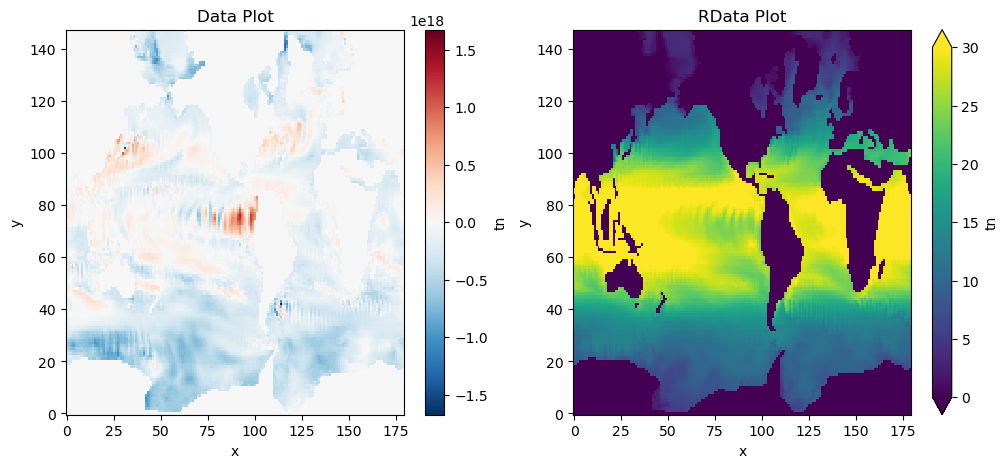

In [ ]:
# Create a figure with two subplots arranged in one row
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
# Plot the first dataset on the first subplot
data['tn'].isel(time_counter=0, nav_lev=0).plot(ax=axes[0]) #vmin=0, vmax=30)
axes[0].set_title('Data Plot')
# Plot the second dataset on the second subplot
rdata['tn'].isel(time_counter=0, nav_lev=0).plot(ax=axes[1], vmin=0, vmax=30)
axes[1].set_title('RData Plot')
# Display the plots
plt.show()

In [ ]:
# ****

In [12]:
reco=False
filename = os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{var}_series_00000.nc")
timeseries = xr.open_mfdataset(filename)
xf = timeseries['time_counter'].isel(time_counter=-1)+yearleap
filename = os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{var}_pattern.nc")
pattern = xr.open_mfdataset(filename)
field = pattern.isel(time_counter=0)*0        
for i in range(window-1):
    filename = os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{var}_series_0000{i}.nc")            
    timeseries = timeseries.squeeze({'zaxis_Reduced', 'lat', 'lon'})
    timeseries = xr.open_mfdataset(filename)
    if (reco == False):
        p = timeseries.polyfit(dim='time_counter', deg=1, skipna = True)
        theta = xr.polyval(xf, p[f"{var}_polyfit_coefficients"])
    else:
        theta = timeseries[var].isel(time_counter=-1)
    basis = pattern.isel(time_counter=i)
    field = field + theta*basis

In [13]:
timeseries = timeseries.isel(lon=0,lat=0,zaxis_Reduced=0)
timeseries = timeseries.drop_vars({'lon', 'lat', 'zaxis_Reduced'})
timeseries

<xarray.Dataset> Size: 60B
Dimensions:       (time_counter: 5)
Coordinates:
  * time_counter  (time_counter) float32 20B 1.996e+03 1.997e+03 ... 2e+03
Data variables:
    tn            (time_counter) float64 40B dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.4.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    file_name:    /ec/res4/scratch/itas/martini/FE01/007/FE01_00035056_restar...
    TimeStamp:    30/08/2024 12:38:50 -0000
    history:      Fri Aug 30 14:17:08 2024: cdo eofcoeff3d /ec/res4/scratch/i...
    CDO:          Climate Data Operators version 2.4.0 (https://mpimet.mpg.de...

In [5]:
field = field.squeeze({'zaxis_Reduced', 'lat', 'lon'})
field

<xarray.Dataset> Size: 7MB
Dimensions:        (nav_lev: 31, y: 148, x: 180)
Coordinates:
    time_counter   float32 4B 1.0
  * nav_lev        (nav_lev) float32 124B 5.0 15.0 25.0 ... 4.75e+03 5.25e+03
    zaxis_Reduced  float64 8B 0.0
    lat            float64 8B 0.0
    lon            float64 8B 0.0
Dimensions without coordinates: y, x
Data variables:
    tn             (nav_lev, y, x) float64 7MB dask.array<chunksize=(1, 1, 180), meta=np.ndarray>

In [11]:
filename = os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{var}_series_00000.nc")
timeseries = xr.open_mfdataset(filename)
xf = timeseries['time_counter'].isel(time_counter=-1)+yearleap
xf

<xarray.DataArray 'time_counter' ()> Size: 4B
array(2010., dtype=float32)
Coordinates:
    time_counter  float32 4B 2e+03

In [11]:
var='tn'
rdata = reader_rebuilt(expname, endleg, endleg)
xf=xr([2010.], dtype=float32)
filename = os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{var}_pattern.nc")
pattern = xr.open_mfdataset(filename)
field = pattern.isel(time_counter=0)*0
for i in range(window-1):
    filename = os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{var}_series_0000{i}.nc")
    timeseries = xr.open_mfdataset(filename)
    timeseries = timeseries.squeeze({'zaxis_Reduced', 'lat', 'lon'})
    p = timeseries.polyfit(dim='time_counter', deg=1, skipna=True)
    theta = xr.polyval(xf, p[f"{var}_polyfit_coefficients"])
    #theta = timeseries[var].isel(time_counter=-1,lat=0,lon=0,zaxis_Reduced=0)
    basis = pattern.isel(time_counter=i)
    field = field + theta*basis
#field = field.isel(time=0,zaxis_Reduced=0,lat=0,lon=0)
#field = field.drop_vars({'time', 'lon', 'lat', 'zaxis_Reduced'})
#field = field.drop_vars({'lon', 'lat', 'zaxis_Reduced'})
field

2024-08-30 14:07:42,834 - INFO -  File to be loaded ['/ec/res4/scratch/itas/martini/FE01/011/FE01_00058432_restart.nc']


NameError: name 'array' is not defined

In [16]:
filename = os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{var}_series_00000.nc")
timeseries = xr.open_mfdataset(filename)
timeseries['time_counter'].isel(time_counter=-1)+yearleap

<xarray.DataArray 'time_counter' ()> Size: 4B
array(2010., dtype=float32)
Coordinates:
    time_counter  float32 4B 2e+03

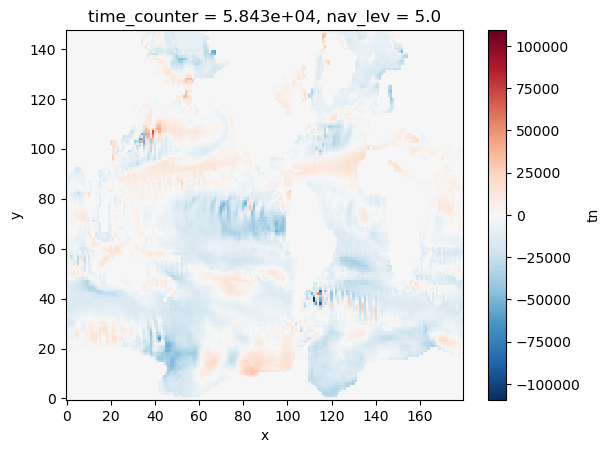

In [6]:
field['tn'].isel(nav_lev=0,time_counter=0).plot()

In [6]:
filename = os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{var}_series_00000.nc")
timeseries = xr.open_mfdataset(filename)
#timeseries = timeseries.isel(zaxis_Reduced=0,lat=0,lon=0)
#timeseries = timeseries.drop_vars({'zaxis_Reduced', 'lat', 'lon'})
timeseries #['time_counter'].values #['tn'].plot()

array([1996., 1997., 1998., 1999., 2000.], dtype=float32)

In [33]:
xf

<xarray.DataArray (time: 1)> Size: 8B
array([cftime.DatetimeGregorian(2000, 1, 1, 0, 0, 0, 0, has_year_zero=False)],
      dtype=object)
Coordinates:
  * time     (time) object 8B 2000-01-01 00:00:00
Attributes:
    stardand_name:  time
    long_name:      Time axis
    bounds:         time_counter_bnds
    axis:           T

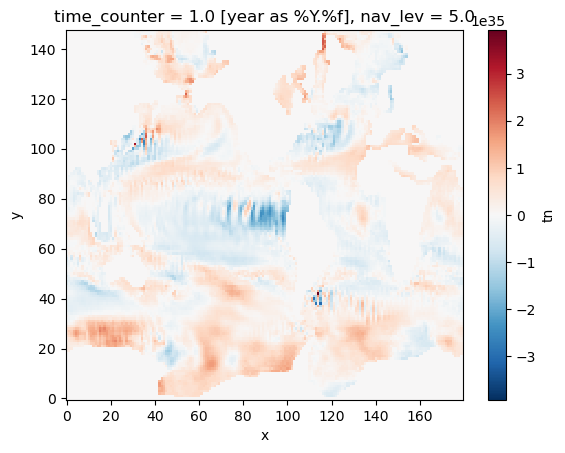

In [45]:
field['tn'].isel(nav_lev=0).plot()

In [47]:
filename = os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{var}.nc")
xdata = xr.open_mfdataset(filename, use_cftime=True)
ave = xdata[var].mean(dim=['time_counter'])
total = field + ave
total

<xarray.Dataset> Size: 7MB
Dimensions:        (nav_lev: 31, time: 1, zaxis_Reduced: 1, lat: 1, lon: 1,
                    y: 148, x: 180)
Coordinates:
    time_counter   float32 4B 1.0
  * nav_lev        (nav_lev) float32 124B 5.0 15.0 25.0 ... 4.75e+03 5.25e+03
  * time           (time) object 8B 2010-01-01 00:00:00
  * zaxis_Reduced  (zaxis_Reduced) float64 8B 0.0
  * lat            (lat) float64 8B 0.0
  * lon            (lon) float64 8B 0.0
Dimensions without coordinates: y, x
Data variables:
    tn             (nav_lev, y, x, time, zaxis_Reduced, lat, lon) float64 7MB dask.array<chunksize=(1, 1, 180, 1, 1, 1, 1), meta=np.ndarray>

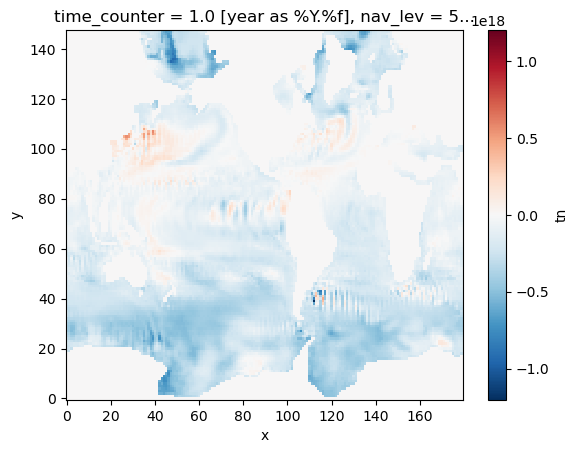

In [50]:
total['tn'].isel(nav_lev=0,zaxis_Reduced=0,lat=0,lon=0, time=0).plot()

In [3]:
run_cdo.merge_rebuilt(expname, startleg, endleg)

Command: 'cdo -selname,tn /ec/res4/scratch/itas/martini/FE00/007/FE00*_restart.nc /ec/res4/scratch/itas/martini/FE00/007/aux.nc' 

/bin/sh: which: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `which'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `module'
/bin/sh: ml: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `ml'

Command: 'cdo -settaxis,1996-01-01,00:00:00,1year /ec/res4/scratch/itas/martini/FE00/007/aux.nc /ec/res4/scratch/itas/martini/FE00/007/tn_7.nc' 

/bin/sh: which: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `which'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `module'
/bin/sh: ml: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `ml'

File /ec/res4/scratch

In [4]:
change_timeaxis(expname, var, startyear, endyear)

File /ec/res4/scratch/itas/martini/FE00/011/tn.nc successfully removed.


In [14]:
filename = os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{var}_anomaly.nc")
xdata = xr.open_mfdataset(filename, use_cftime=True)
xdata

<xarray.Dataset> Size: 33MB
Dimensions:       (time_counter: 5, nav_lev: 31, y: 148, x: 180)
Coordinates:
  * time_counter  (time_counter) object 40B 1996-01-01 00:00:00 ... 2000-01-0...
  * nav_lev       (nav_lev) float32 124B 5.0 15.0 25.0 ... 4.75e+03 5.25e+03
Dimensions without coordinates: y, x
Data variables:
    tn            (time_counter, nav_lev, y, x) float64 33MB dask.array<chunksize=(1, 1, 1, 180), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.4.0 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    file_name:    /ec/res4/scratch/itas/martini/FE00/007/FE00_00035056_restar...
    TimeStamp:    25/06/2024 15:31:27 -0000
    history:      Thu Jul 04 08:37:57 2024: cdo sub /ec/res4/scratch/itas/mar...
    CDO:          Climate Data Operators version 2.4.0 (https://mpimet.mpg.de...

In [7]:
run_cdo.detrend(expname, var, endleg)
run_cdo.get_EOF(expname, var, endleg, window)

File /ec/res4/scratch/itas/martini/FE00/011/tn_anomaly.nc successfully removed.
Command: 'cdo sub /ec/res4/scratch/itas/martini/FE00/011/tn.nc -timmean /ec/res4/scratch/itas/martini/FE00/011/tn.nc /ec/res4/scratch/itas/martini/FE00/011/tn_anomaly.nc' 
cdo    sub: Filling up stream2 >(pipe1.4)< by copying the first timestep.

/bin/sh: which: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `which'
/bin/sh: module: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `module'
/bin/sh: ml: line 1: syntax error: unexpected end of file
/bin/sh: error importing function definition for `ml'

 Time window  5
File /ec/res4/scratch/itas/martini/FE00/011/tn_variance.nc successfully removed.
File /ec/res4/scratch/itas/martini/FE00/011/tn_pattern.nc successfully removed.
Command: 'cdo eof3d,5 /ec/res4/scratch/itas/martini/FE00/011/tn_anomaly.nc /ec/res4/scratch/itas/martini/FE00/011/tn_variance.nc /ec/res4/scratch

In [25]:
filename = os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{var}_pattern.nc")
pattern = xr.open_mfdataset(filename, use_cftime=True)
field = pattern.isel(time_counter=0)*0
for i in range(window):
    filename = os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{var}_series_0000{i}.nc")
    timeseries = xr.open_mfdataset(filename, use_cftime=True)
    theta = timeseries[var].isel(time_counter=-1,lat=0,lon=0,zaxis_Reduced=0)
    basis = pattern.isel(time_counter=i)
    field = field + theta*basis
field = field.drop_vars({'time_counter', 'lon', 'lat', 'zaxis_Reduced'})

In [26]:
filename = os.path.join(dirs['tmp'], str(endleg).zfill(3), f"{var}.nc")
xdata = xr.open_mfdataset(filename, use_cftime=True)
xdata = xdata.rename({'time_counter': 'time'})
ave = timemean(xdata, var)
total = field + ave
total

<xarray.Dataset> Size: 7MB
Dimensions:  (nav_lev: 31, y: 148, x: 180)
Coordinates:
  * nav_lev  (nav_lev) float32 124B 5.0 15.0 25.0 ... 4.25e+03 4.75e+03 5.25e+03
Dimensions without coordinates: y, x
Data variables:
    tn       (nav_lev, y, x) float64 7MB dask.array<chunksize=(1, 1, 180), meta=np.ndarray>

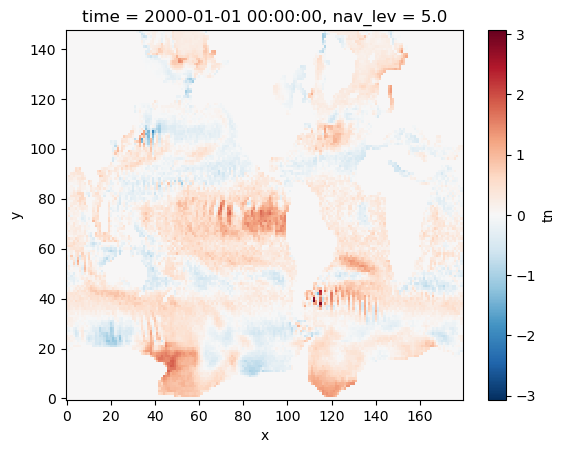

In [27]:
delta = xdata[var].isel(time=-1,nav_lev=0)-total[var].isel(nav_lev=0)
delta.plot()

In [28]:
df = elements(expname)

In [29]:
rpa = xdata[var].isel(time=-1).weighted(df['S']).mean(dim=['y', 'x'])
fpa = total[var].weighted(df['S']).mean(dim=['y', 'x'])

Text(0, 0.5, 'T')

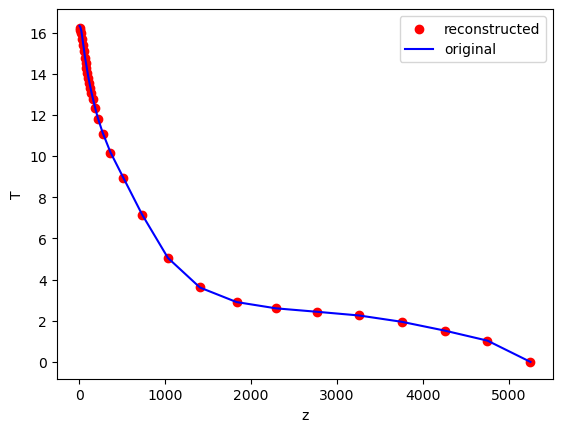

In [30]:
plt.scatter(fpa['nav_lev'].values,fpa.values, color='r', label='reconstructed')
plt.plot(rpa['nav_lev'].values,rpa.values, color='b', label='original')
plt.legend(loc="upper right")
plt.xlabel('z')
plt.ylabel('T')

Text(0, 0.5, 'T diff')

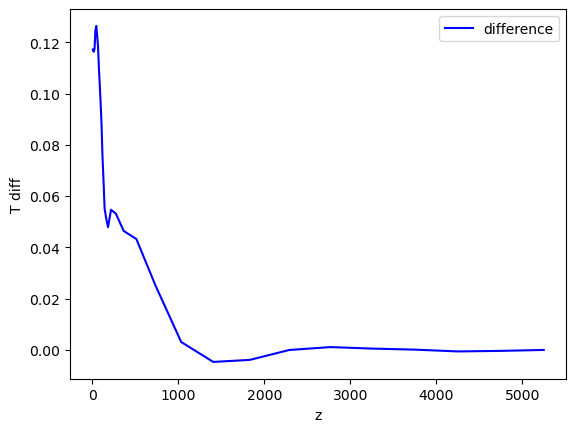

In [31]:
dpa = rpa-fpa 
plt.plot(rpa['nav_lev'].values, dpa.values, color='b', label='difference')
plt.legend(loc="upper right")
plt.xlabel('z')
plt.ylabel('T diff')